# Introduction :

**In this notebook we will use various machine learnning models in order to evaluate how accurate they are in detecting customer satisfaction in the airline industry. We used the Aireline sentiment analysis from kaggle we've focused on two features:**
*             **airline_sentiment**
*             **Text**


**Our Goals :**

* **Understand the  distribution of the  data that was provided to us.**
* **Create a balanced dataframe of "positive", "neutral" and "negative" comments using EDA (easy data augmentation)  and see the impact of this technique on our models**
* **Determine the Classifiers we are going to use and decide which one has a higher accuracy.**
* **Understand common mistakes made with imbalanced datasets.**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing packages that we need
import numpy as np 
import pandas as pd 
# Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# I- Dataset

## 1.1. importing dataset

In [4]:
pd.options.mode.chained_assignment = None  
df = pd.read_csv('Tweets.csv',index_col=None)
df=df[['airline_sentiment','text']]
df.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


## 1.2. exploring dataset

In [5]:
df.shape

(14640, 2)

In [6]:
#different sentiments
sentiments = set(df['airline_sentiment'])
print('Sentiments', sentiments)

Sentiments {'negative', 'neutral', 'positive'}


#### wordcloud

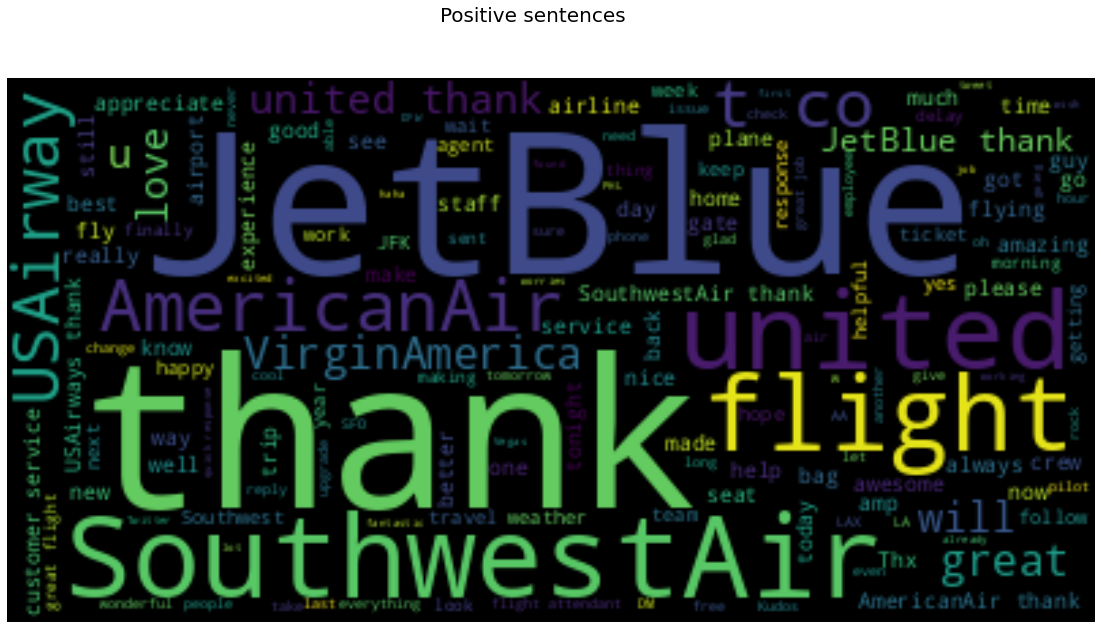

In [7]:
#extraction Positive Keywords
from collections import Counter

def extract_keywords(text,num=50):
    tokens=[tok for tok in text.split()]
    most_commen_tokens=Counter(tokens).most_common(num)
    return dict(most_commen_tokens)
#sentiment list
sentiment_list=df['airline_sentiment'].unique().tolist()
positive_list=df[df['airline_sentiment']=='positive']['text'].tolist()
positive_docx=' '.join(positive_list)
keywords_positive=extract_keywords(positive_docx)
np.array(keywords_positive)


#Word Cloud
from wordcloud import WordCloud
def plot_wordcloud(docx):
    mywordcloud=WordCloud().generate(docx)
    plt.figure(figsize=(20,10))
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.suptitle('Positive sentences', fontsize=20)
    
    plt.show()
    
plot_wordcloud(positive_docx) 

In [8]:
#Distribution
print('negative', round(df['airline_sentiment'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('neutral', round(df['airline_sentiment'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('positive', round(df['airline_sentiment'].value_counts()[2]/len(df) * 100,2), '% of the dataset')

negative 62.69 % of the dataset
neutral 21.17 % of the dataset
positive 16.14 % of the dataset


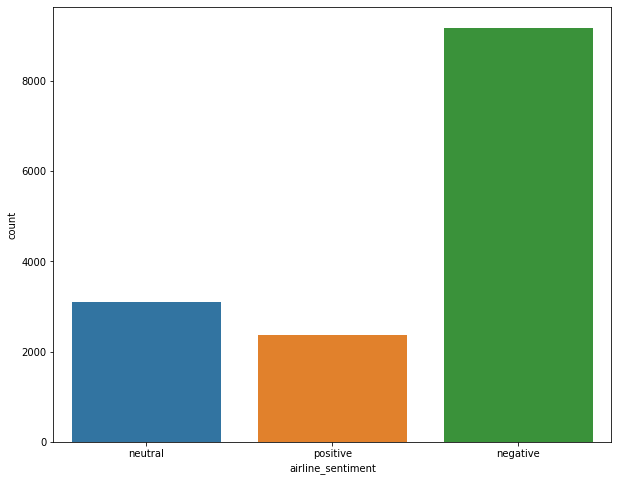

In [9]:
plt.figure(figsize = (10, 8))
sns.countplot(x=df['airline_sentiment'])
plt.show()

**Note:**

**Notice how imbalanced is our original dataset! Most of the comments are negative. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most customers are unsatisfied with the airline services. But we don't want our model to assume, we want our model to detect the correct customer satisfaction.**

# II- Pre-Processing

In [10]:
from textblob import Word 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
lemmatizer = WordNetLemmatizer()

In [11]:
!pip install contractions
!pip install nltk
!pip install neattext
!pip install pyenchant
!pip install emoji

     |████████████████████████████████| 106 kB 296 kB/s            
     |████████████████████████████████| 284 kB 1.4 MB/s            
     |████████████████████████████████| 114 kB 291 kB/s            
     |████████████████████████████████| 55 kB 272 kB/s            


In [12]:
!apt -y install enchant --fix-missing 




The following additional packages will be installed:
  aspell aspell-en libaspell15 libenchant1c2a
Suggested packages:
  aspell-doc spellutils libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en enchant libaspell15 libenchant1c2a
0 upgraded, 5 newly installed, 0 to remove and 33 not upgraded.
Need to get 792 kB of archives.
After this operation, 3470 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libaspell15 amd64 0.60.8-1ubuntu0.1 [328 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 aspell amd64 0.60.8-1ubuntu0.1 [88.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 aspell-en all 2018.04.16-0-1 [299 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libenchant1c2a amd64 1.6.0-11.3build1 [64.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/universe amd64 enchant amd64 1.6.0-11.3build1 [12.4 kB]
Fetched 792 kB in 2s (344 kB/s)

78Selecting previou

In [13]:
#we noticed that our data contains insignificant words
import enchant
def check_meaning_words(data,column):
                    d = enchant.Dict("en_US")
                    i=0
                    for sentence in data[column]:
                                l=[]
                                for token in sentence:
                                     if d.check(str(token)):
                                            l+=[token]
                                data[column][i]=l
                                i=i+1 
                    return data[column]    


In [14]:
#convert links to string
import re
def convert_links_to_text(text):
         new = re.sub(r'^https?:\/\/.*[\r\n]*', 'link', text, flags=re.MULTILINE)
         return new

In [15]:
#convert emails to string
def convert_emails_to_text(text):
         new1 = re.sub(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+', 'email', text, flags=re.MULTILINE)
         return new1

In [16]:
import emoji
def convert_emojis_to_text(text):
          new=emoji.demojize(text, delimiters=("", "")) 
          return new

In [17]:
def remove_redundant_chars(data,column):
            i=0
            for sentence in data[column]:
                l=[]
                for token in sentence:
                    if 'aa' in token:
                            repeat_pattern = re.compile(r'(\w)\1*')
                            y=repeat_pattern.sub(r'\1',token)
                            #y=re.sub(r"(.)\1\1+", r"\1\1", token)
                    else:
                        y=token
                    l+=[y]
                data[column][i]=l
                i=i+1
            return data[column]    

In [18]:
import contractions
def fix_contractions(data,column):
        i=0
        for sentence in data[column]:
            expanded_words=[]
            for word in sentence:
                        expanded_words+=[contractions.fix(word)]
            data[column][i]=expanded_words
            i=i+1
        return data[column]

In [19]:
import neattext.functions as nfx
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
#     nltk.download('wordnet')
#     nltk.download('punkt')
#     nltk.download('stopwords')

#cleaning fct
def clean_data(data,column):
    #convert text to lower
    data[column]=data[column].str.lower()
    #remove numbers
    data[column]=data[column].apply(nfx.remove_numbers)
    #remove userhandles
    data[column]=data[column].apply(nfx.remove_userhandles)
    #remove punctuations
    data[column]=data[column].apply(nfx.remove_punctuations)
    #remove special characters
    data[column]=data[column].apply(nfx.remove_special_characters)
    #remove hashtags
    data[column]=data[column].apply(nfx.remove_hashtags)
    #remove some words 
    data[column].replace("amp", " ", regex=True, inplace=True)
    #remove multiple space
    data[column]=data[column].apply(nfx.remove_multiple_spaces)
    #lemmatization
    data[column]=data[column].apply(lambda x: " ".join([lemmatizer.lemmatize(word,wordnet.VERB) for word in x.split()]))
    data[column]=data.apply(lambda row: convert_emojis_to_text(row[column]), axis=1)
    data[column]=data.apply(lambda row: convert_links_to_text(row[column]), axis=1)
    data[column]=data.apply(lambda row: convert_emails_to_text(row[column]), axis=1)
    data['tokenized_sents'] = data.apply(lambda row: nltk.word_tokenize(row[column]), axis=1)
    data['tokenized_sents']=check_meaning_words(data,'tokenized_sents')
    data['tokenized_sents']=remove_redundant_chars(data,'tokenized_sents')
    data['tokenized_sents']=fix_contractions(data,'tokenized_sents')
    data['detokenized_sents'] = data.apply(lambda row: TreebankWordDetokenizer().detokenize(row['tokenized_sents']), axis=1)
    data=data[data['detokenized_sents'].str.len()>=4]
    #delete empty rows
    data = data[data['detokenized_sents']!= '']
    #reset data index
    data=data.reset_index().drop('index',axis=1)
    return data

In [20]:
data=clean_data(df,'text')
data.head()

,airline_sentiment,text,tokenized_sents,detokenized_sents
0,neutral,what say,"[what, say]",what say
1,positive,plus youve add commercials to the experience t...,"[plus, add, commercials, to, the, experience, ...",plus add commercials to the experience tacky
2,neutral,i didnt today must mean i need to take another...,"[i, today, must, mean, i, need, to, take, anot...",i today must mean i need to take another trip
3,negative,its really aggressive to blast obnoxious enter...,"[its, really, aggressive, to, blast, obnoxious...",its really aggressive to blast obnoxious enter...
4,negative,and its a really big bad thing about it,"[and, its, a, really, big, bad, thing, about, it]",and its a really big bad thing about it


## Split Data

In [21]:
from sklearn.model_selection import train_test_split
X=data['detokenized_sents']
y=data['airline_sentiment']
#we used  80% for training data and 20% for testing
train,valid=train_test_split(data[['detokenized_sents','airline_sentiment']],test_size=0.2, random_state=42)

print(len(train))
print(len(valid))

11662
2916


# III- Easy Data Augmentation EDA

**Easy data augmentation refers to a set of technics used for boosting text classification tasks:**

1. **SR : Synonym Replacement**
2. **RD : Random Deletion**
3. **RS : Random Swap**
4. **RI : Random Insertion**

**Note** : It's recommended to apply EDA on the training subset and not the whole dataset. A validation subset from the original dataset is set aside for evaluating the model's performance at the end.

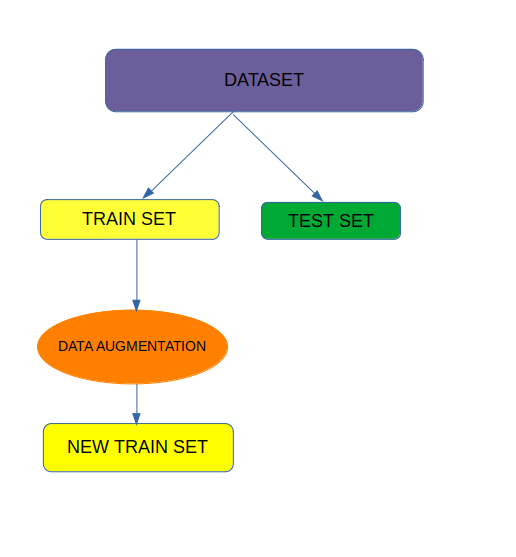

## 3.1.  Synonyme replacement (SR)

Synonym replacement is a technique in which we replace a word by one of its synonyms For identifying relevent Synonyms we use WordNet.

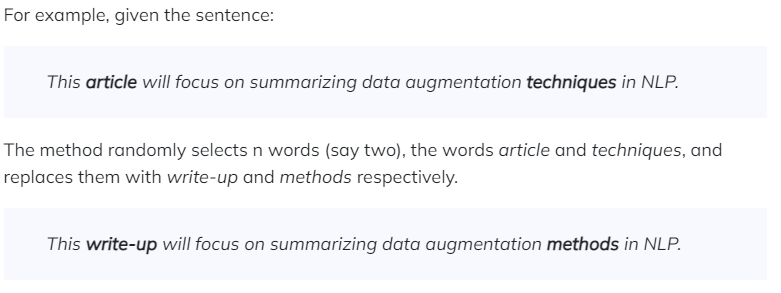

In [22]:
#We define the get_synonyms function to retrieve pre-processed list of synonyms of a given word
from nltk.corpus import wordnet
def get_synonyms(word):
    
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [23]:
from nltk.corpus import stopwords
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
print(list(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
import random
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

**Note** : you can play around with the n parameter in synonym_replacement to get new sentences in each iteration.

In [25]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']
for i in train.index:
    if train['airline_sentiment'][i]== 'positive' or train['airline_sentiment'][i]== 'neutral':
        new_row=synonym_replacement(train['detokenized_sents'][i],2)
        aug_syn['airline_sentiment'].append(train['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data1 = pd.DataFrame(aug_syn, columns=columns, index=None)
df = train.append(data1,ignore_index=True)
df

,detokenized_sents,airline_sentiment
0,i want the flight i have on hold i want a new ...,negative
1,couple with cut exacerbate the note issue,negative
2,i have a question,neutral
3,flt land over half an hour ago not a single ba...,negative
4,it should be free like other airlines again it...,negative
...,...,...
15959,for haunt miles can we schedule interchangeabl...,neutral
15960,thank for the absolve birthday point be all in...,positive
15961,disconsolate consider i do its do now,neutral
15962,i be happy to purchase the rise if only it be ...,positive


## 3.2. Random Deletion (RD)

In Random Deletion, we randomly delete a word if a uniformly generated number between 0 and 1 is smaller than a pre-defined threshold. This allows for a random deletion of some words of the sentence.

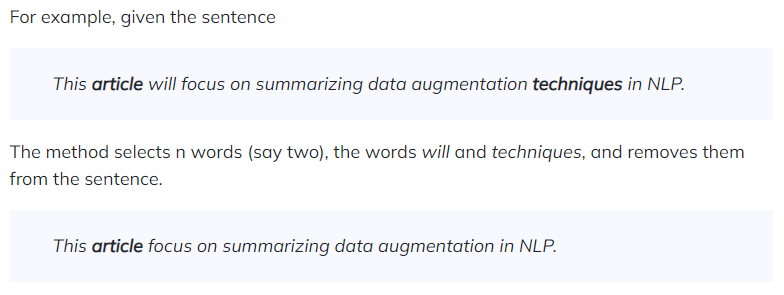

In [26]:
def random_deletion(words, p):
    words = words.split()
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence

In [27]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']
for i in df.index:
    if df['airline_sentiment'][i]== 'positive' or df['airline_sentiment'][i]== 'neutral':
        new_row=random_deletion(df['detokenized_sents'][i],0.2)
        aug_syn['airline_sentiment'].append(df['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data2 = pd.DataFrame(aug_syn, columns=columns, index=None)
df1 = df.append(data2,ignore_index=True)
df1

,detokenized_sents,airline_sentiment
0,i want the flight i have on hold i want a new ...,negative
1,couple with cut exacerbate the note issue,negative
2,i have a question,neutral
3,flt land over half an hour ago not a single ba...,negative
4,it should be free like other airlines again it...,negative
...,...,...
24563,for haunt miles can schedule interchangeably a...,neutral
24564,thank the absolve birthday be good order with me,positive
24565,disconsolate consider i its do now,neutral
24566,be happy to rise if it service on next flight,positive


## 3.3.  Random Swap (RS)

In Random Swap, we randomly swap the order of two words in a sentence.

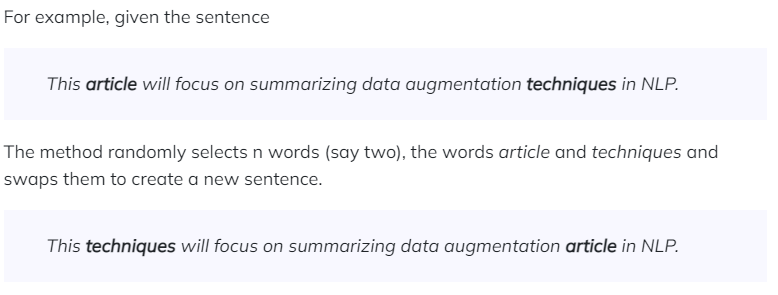

In [28]:
# This will Swap the words
def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n):
    
    words = words.split()
    new_words = words.copy()
    # n is the number of words to be swapped
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

In [29]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']
for i in range(3000):
    if df1['airline_sentiment'][i]== 'positive' or df1['airline_sentiment'][i]== 'negative':
        new_row=random_swap(df1['detokenized_sents'][i], 1)
        aug_syn['airline_sentiment'].append(df1['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data3 = pd.DataFrame(aug_syn, columns=columns, index=None)
df2 = df1.append(data3,ignore_index=True)
df2

,detokenized_sents,airline_sentiment
0,i want the flight i have on hold i want a new ...,negative
1,couple with cut exacerbate the note issue,negative
2,i have a question,neutral
3,flt land over half an hour ago not a single ba...,negative
4,it should be free like other airlines again it...,negative
...,...,...
26931,id love to but my seat take it appear as thoug...,negative
26932,be fly soon to on your airline to all airlines...,positive
26933,gate staff a disaster overbooked no volunteer ...,negative
26934,stick in need book problems flight next for po...,negative


## 3.4. Random Insertion (RI)

Finally, in Random Insertion, we randomly insert synonyms of a word at a random position.

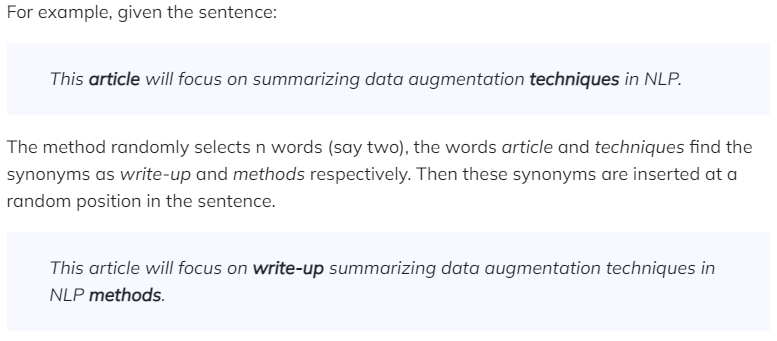

Data augmentation operations should not change the true label of a sentence, as that would introduce unnecessary noise into the data. Inserting a synonym of a word in a sentence, opposed to a random word, is more likely to be relevant to the context and retain the original label of the sentence.

In [30]:
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

In [31]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']

for i in range(2000):
    if df2['airline_sentiment'][i]== 'positive' :
        new_row=random_insertion(df2['detokenized_sents'][i], 1)
        aug_syn['airline_sentiment'].append(df2['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data4 = pd.DataFrame(aug_syn, columns=columns, index=None)
df3 = df2.append(data4,ignore_index=True)
df3

,detokenized_sents,airline_sentiment
0,i want the flight i have on hold i want a new ...,negative
1,couple with cut exacerbate the note issue,negative
2,i have a question,neutral
3,flt land over half an hour ago not a single ba...,negative
4,it should be free like other airlines again it...,negative
...,...,...
27242,please send station me the to formally complim...,positive
27243,i be well take care of thank easily already be...,positive
27244,that just make my day i look and just find tha...,positive
27245,have a great flight to from a few weeks ago be...,positive


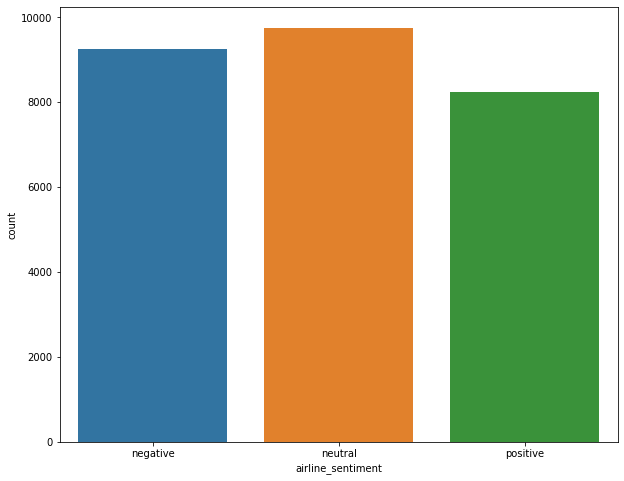

In [32]:
#we can see that our data is balanced
plt.figure(figsize = (10, 8))
sns.countplot(x=df3['airline_sentiment'])
plt.show()

to study the influence of easy data augmentation, we will implement machine learning algorithms on our dataset before and after applying EDA:

# IV- Modeling using training set without EDA

## 4.1. The word embedding technique: TF-IDF

TF-IDF is a statistical measure used to determine the mathematical significance of words in documents. The vectorization process is similar to One Hot Encoding. Alternatively, the value corresponding to the word is assigned a TF-IDF value instead of 1. The TF-IDF value is obtained by multiplying the TF and IDF values.

In [33]:
#NGrams
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)#it will takes uni_grams,bigrams(max)
vectorizer.fit(list(train['detokenized_sents'].values))
X_train=train['detokenized_sents']
X_test=valid['detokenized_sents']
y_train=train['airline_sentiment']
y_test=valid['airline_sentiment']
train_vectorized = vectorizer.transform(X_train)
test_vectorized = vectorizer.transform(X_test)

In [34]:
#getFreatures
ngramFeatures = vectorizer.get_feature_names()
np.array(ngramFeatures)

array(['a', 'a a', 'a able', ..., 'zoom', 'zoom in', 'zoom out'],
      dtype='<U29')

## 4.2-Implementing machine learning algorithms:

**Note**: we decided to use two binary classification algorithms: Logistic Regression and SVM,  to see their function on multiclass problems.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix

### 4.2.1. Logistic Regression

In [36]:
lr = LogisticRegression()
lr.fit(train_vectorized,y_train)
print(confusion_matrix(lr.predict(test_vectorized ) , y_test))
print()
print(classification_report( lr.predict(test_vectorized ) , y_test))
print("accuracy: ",accuracy_score( lr.predict(test_vectorized ) , y_test ))

[[1736  328  176]
 [  47  267   35]
 [  25   26  276]]

              precision    recall  f1-score   support

    negative       0.96      0.78      0.86      2240
     neutral       0.43      0.77      0.55       349
    positive       0.57      0.84      0.68       327

    accuracy                           0.78      2916
   macro avg       0.65      0.79      0.70      2916
weighted avg       0.85      0.78      0.80      2916

accuracy:  0.7815500685871056


### 4.2.2. Support Vector Machine (SVM)

In [37]:
from nltk import probability
svm = SVC(probability=True)
svm.fit(train_vectorized,y_train)
print(classification_report(svm.predict(test_vectorized) , y_test))
print("accuracy: ",accuracy_score( svm.predict(test_vectorized) , y_test ))

              precision    recall  f1-score   support

    negative       0.97      0.75      0.85      2321
     neutral       0.35      0.78      0.48       277
    positive       0.56      0.85      0.67       318

    accuracy                           0.77      2916
   macro avg       0.62      0.80      0.67      2916
weighted avg       0.86      0.77      0.79      2916

accuracy:  0.7678326474622771


### 4.2.3. Voting Classifier

In [38]:
#combination svm and LR
estimators = [ ('svm',svm) , ('lr' , lr) ]
clf = VotingClassifier(estimators , voting='soft')
clf.fit(train_vectorized,y_train)
print(classification_report( clf.predict(test_vectorized) , y_test))
print("accuracy: ",accuracy_score( clf.predict(test_vectorized) , y_test ))

              precision    recall  f1-score   support

    negative       0.93      0.81      0.87      2073
     neutral       0.50      0.73      0.60       425
    positive       0.68      0.79      0.73       418

    accuracy                           0.80      2916
   macro avg       0.71      0.78      0.73      2916
weighted avg       0.83      0.80      0.81      2916

accuracy:  0.7983539094650206


# V- Modeling using training set with EDA

## 5.1. The word embedding technique: TF-IDF

In [39]:
#split data into training and validation set
X=df3['detokenized_sents']
Y=df3['airline_sentiment']
X_train1, X_test1, y_train1, y_test1=train_test_split(X,Y,test_size=0.2, random_state=42)

In [40]:
tokenizer1 = TweetTokenizer()
vectorizer1 = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer1.tokenize)
X_train2=["".join(review) for review in X_train1.values]
vectorizer1.fit(X_train2)
X_test2=["".join(review) for review in X_test1.values]
vectorizer1.fit(X_test2)
#vectorization
train_vectorized1 = vectorizer1.transform(X_train2)
test_vectorized1 = vectorizer1.transform(X_test2)

## 5.2. Implementing machine learning algorithms:

### 5.2.1. Logistic Regression

In [41]:
lr = LogisticRegression()
lr.fit(train_vectorized1,y_train1)
print(confusion_matrix(lr.predict(test_vectorized1 ) , y_test1))
print()
print(classification_report( lr.predict(test_vectorized1 ) , y_test1))
print("accuracy: ",accuracy_score( lr.predict(test_vectorized1 ) , y_test1 ))

[[1430   60   34]
 [ 308 1861  214]
 [  90   82 1371]]

              precision    recall  f1-score   support

    negative       0.78      0.94      0.85      1524
     neutral       0.93      0.78      0.85      2383
    positive       0.85      0.89      0.87      1543

    accuracy                           0.86      5450
   macro avg       0.85      0.87      0.86      5450
weighted avg       0.86      0.86      0.86      5450

accuracy:  0.8554128440366973


### 5.2.2. Support Vector Machine (SVM)

In [42]:
svm = SVC(probability=True)
svm.fit(train_vectorized1,y_train1)
print(classification_report(svm.predict(test_vectorized1) , y_test1))
print("accuracy: ",accuracy_score( svm.predict(test_vectorized1 ) , y_test1 ))

              precision    recall  f1-score   support

    negative       0.84      0.98      0.91      1568
     neutral       0.96      0.85      0.90      2278
    positive       0.93      0.94      0.93      1604

    accuracy                           0.91      5450
   macro avg       0.91      0.92      0.91      5450
weighted avg       0.92      0.91      0.91      5450

accuracy:  0.9111926605504587


### 5.2.3. Voting Classifier

In [43]:
#combination svm and LR
estimators = [ ('svm',svm) , ('lr' , lr) ]
clf = VotingClassifier(estimators , voting='soft')
clf.fit(train_vectorized1,y_train1)
print(classification_report( clf.predict(test_vectorized1) , y_test1))
print("accuracy: ",accuracy_score( clf.predict(test_vectorized1) , y_test1 ))

              precision    recall  f1-score   support

    negative       0.86      0.97      0.92      1624
     neutral       0.95      0.86      0.91      2210
    positive       0.93      0.93      0.93      1616

    accuracy                           0.92      5450
   macro avg       0.91      0.92      0.92      5450
weighted avg       0.92      0.92      0.92      5450

accuracy:  0.9155963302752294


**Note:  we can see that the accuracy of our models has improved after using the EDA technique**

# VI- Best model selection using ROC-AUC curve

In [44]:
# Import label encoder
from sklearn import preprocessing
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels
y_test2= label_encoder.fit_transform(y_test1)

def roc_auc_curve():
              pred_prob1 = lr.predict_proba(test_vectorized1) #Logistic regression
              pred_prob2 = svm.predict_proba(test_vectorized1)#svm
              pred_prob3 = clf.predict_proba(test_vectorized1)#voting classifier
              
              #for the positive class
              # roc curve for models
              fpr1, tpr1, _ = roc_curve(y_test2, pred_prob1[:,1], pos_label=1)
              fpr2, tpr2, _ = roc_curve(y_test2, pred_prob2[:,1], pos_label=1)
              fpr3, tpr3, _ = roc_curve(y_test2, pred_prob3[:,1], pos_label=1)
              
              # roc curve for tpr = fpr
              random_probs = [0 for i in range(len(y_test2))]
              p_fpr, p_tpr, _ = roc_curve(y_test2, random_probs, pos_label=1)
              # auc scores
              auc_score1 = roc_auc_score(y_test2, pred_prob1,multi_class='ovr')# logistic regression
              auc_score2 = roc_auc_score(y_test2, pred_prob2,multi_class='ovr')# svm
              auc_score3 = roc_auc_score(y_test2, pred_prob3,multi_class='ovr')# voting classifier
             

              plt.style.use('seaborn')
              # plot roc curves
              plt.plot(fpr1, tpr1, linestyle='--',color='orange',label="Logistic Regression: AUC="+str(auc_score1))
              plt.plot(fpr2, tpr2, linestyle='--',color='green', label='SVM: AUC='+str(auc_score2))
              plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Voting Classifier : AUC='+str(auc_score3))
          

              # plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
              plt.plot([0, 1], [0, 1],'r--')

              # title
              plt.title('ROC curve: ')
              # x label
              plt.xlabel('False Positive Rate')
              # y label
              plt.ylabel('True Positive rate')
              plt.legend(loc='best')
              plt.savefig('ROC',dpi=300)
              plt.show(); 

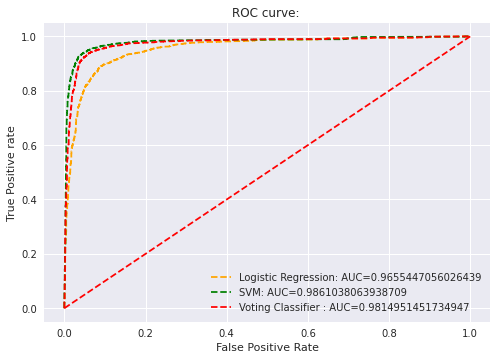

In [45]:
roc_auc_curve()

**Note : we can see that svm is the best model in our case.**

# VII- Test More data

## 7.1. Using validation subset

To know how well does our model preform, we test it on a subset of data that it has never seen to confirm the results we got on training and testing phases since it provides an unbiased final model performance metric in terms of accuracy, precision..etc

In [46]:
#vectorize the text
test =vectorizer1.transform(valid['detokenized_sents'])
            
print(classification_report( svm.predict(test) , valid['airline_sentiment']))
print("accuracy: ",accuracy_score( svm.predict(test) , valid['airline_sentiment']))

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      1822
     neutral       0.64      0.62      0.63       644
    positive       0.68      0.74      0.71       450

    accuracy                           0.79      2916
   macro avg       0.73      0.74      0.73      2916
weighted avg       0.79      0.79      0.79      2916

accuracy:  0.7853223593964335


we can see that our model can generalize and make accurate classifications on the data it has not seen before.

## 7.2. using new phrases

In [47]:
#create a function  that takes a text as input and return the suitable sentiment 
def detect_sentment(text):
            #vectorize the text
            test = vectorizer1.transform([text])
            l=svm.predict(test)
            #Check for the prediction probability
            pred_proba=svm.predict_proba(test)
            pred_percentage_for_all=dict(zip(svm.classes_,pred_proba[0]))
            print("Prediction using SVM:  : {} , Prediction Score : {}".format(l[0],np.max(pred_proba)))
            print()
            print(pred_percentage_for_all)

In [48]:
detect_sentment("it's good to see you!")

Prediction using SVM:  : positive , Prediction Score : 0.9685143352794001

{'negative': 0.0006991567905436434, 'neutral': 0.030786507930056137, 'positive': 0.9685143352794001}


In [49]:
detect_sentment("i'm not satisfied")

Prediction using SVM:  : negative , Prediction Score : 0.9992180695017459

{'negative': 0.9992180695017459, 'neutral': 0.0007804662792115126, 'positive': 1.4642190426417434e-06}


In [50]:
detect_sentment("i took a flight today!")

Prediction using SVM:  : negative , Prediction Score : 0.5417386987434136

{'negative': 0.5417386987434136, 'neutral': 0.33187090432645105, 'positive': 0.12639039693013535}


# VIII- Error Analysis

In [51]:
def plotTopErrors(y_predict, top=5):
    ys = y_test.values
    Xs = X_test.values
    errorCount = 0
    
    for i in range(len(ys)):
        if not ys[i]==y_predict[i]:
            errorCount += 1
            print("#{}: Expected: {}, Predicted: {}".format(errorCount, ys[i], y_predict[i]))
            print("Text:", Xs[i])
            print("=================================================")
        if errorCount >= top:
            break

analyse errors of our final model

In [52]:
plotTopErrors(svm.predict(test_vectorized1), top=10)

#1: Expected: negative, Predicted: neutral
Text: my sister just receive a call that her trip be cancel and to next day why
#2: Expected: negative, Predicted: neutral
Text: give us no information and an attitude
#3: Expected: neutral, Predicted: positive
Text: want customs at long beach airport for future international flight by cc
#4: Expected: negative, Predicted: neutral
Text: i need a flight out tonight there anything else
#5: Expected: negative, Predicted: neutral
Text: have make my no fly list other airlines wait when connector late flight stick in
#6: Expected: negative, Predicted: positive
Text: what is the hold up with flight board take place minutes ago
#7: Expected: neutral, Predicted: positive
Text: alright i hope my app be show a change in my seat and online show an a want any surprise
#8: Expected: positive, Predicted: neutral
Text: it be customer service like i have never see before kudos to your organization
#9: Expected: neutral, Predicted: positive
Text: to come to see

# Thank you !